In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv("bike_rental_hour.csv")

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


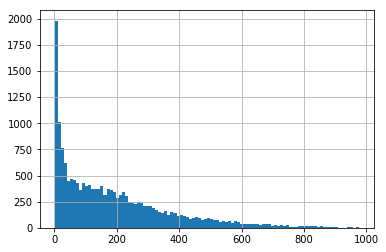

In [6]:
df['cnt'].hist(bins=100)

In [7]:
correlations = df.corr()['cnt'].abs().sort_values(ascending=False)

In [8]:
correlations

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Correlations with the target column 'cnt' shows high correlation with 'registered' and 'casual' ('cnt'='registered'+'casual', so we can't use it for predictions) and extremely low correlation with 'holiday', 'workingday', 'weekday', and it seems reasonable to dissmiss those columns. Also we should dissmiss column 'instant', because it is an ID for each row.

In [9]:
(df['yr'].min(), df['yr'].max())

(0, 1)

It seems dataset already has a precomputed values for 'yr' (year) column. From documentation: "yr - The year the rentals occurred"

Let's calculate additional time labeling based on 'hr' (hour) of rental in order to split it in 4 categories (morning, day, evening, night)

In [10]:
def time_labeling(hr):
    if 0 <= hr < 6:
        return 0
    elif 6 <= hr < 12:
        return 1
    elif 12 <= hr < 18:
        return 2
    else:
        return 3

In [11]:
df['time_label'] = df['hr'].apply(time_labeling)

Now lets convert it to categorical representation

In [12]:
time_labels_ctg = df['time_label'].astype('category')
col_dummies = pd.get_dummies(time_labels_ctg, prefix='time_label')
df = pd.concat([df, col_dummies], axis=1)

In [13]:
df.corr()['cnt'].sort_values(ascending=False)

cnt             1.000000
registered      0.972151
casual          0.694564
time_label      0.422126
temp            0.404772
atemp           0.400929
hr              0.394071
time_label_2    0.339037
instant         0.278379
yr              0.250495
season          0.178056
mnth            0.120638
time_label_3    0.115939
windspeed       0.093234
time_label_1    0.059463
workingday      0.030284
weekday         0.026900
holiday        -0.030927
weathersit     -0.142426
hum            -0.322911
time_label_0   -0.518261
Name: cnt, dtype: float64

Since it is a regression (not classification) problem, let's use mse for error metrics.

# Getting data ready

In [14]:
train = df.sample(frac=0.8)

In [15]:
test = df.loc[~df.index.isin(train.index)]

In [16]:
corrs = df.corr()['cnt'].abs().sort_values(ascending=False)
features = corrs[corrs > 0.2]

In [17]:
features

cnt             1.000000
registered      0.972151
casual          0.694564
time_label_0    0.518261
time_label      0.422126
temp            0.404772
atemp           0.400929
hr              0.394071
time_label_2    0.339037
hum             0.322911
instant         0.278379
yr              0.250495
Name: cnt, dtype: float64

In [18]:
features = ['time_label_0', 'time_label', 'temp', 'atemp', 'hr', 'time_label_2', 'hum']

In [19]:
def compare_predictions(predicted, test, target_col):
    check_df = pd.DataFrame(data=predicted, index=test.index, columns=["Predicted "+target_col])
    check_df = pd.concat([check_df, test[[target_col]]], axis=1)
    #check_df[target_col] = test[target_col]
    check_df["Error, %"] = np.abs(check_df["Predicted "+target_col]*100/check_df[target_col] - 100)
    check_df['Error, val'] = check_df["Predicted "+target_col] - check_df[target_col]
    return (check_df.sort_index(), check_df["Error, %"].mean())

In [20]:
def evaluate_predictions(model, train, test, features=features):
    train_pred = model.predict(train[features])
    train_rmse = mean_squared_error(train_pred, train['cnt']) ** 0.5

    test_pred = model.predict(test[features])
    test_rmse = mean_squared_error(test_pred, test['cnt']) ** 0.5

    print("RMSE TRAIN AND TEST:")
    print(train_rmse, test_rmse)
    
    return test_pred

# Linear Regression approach

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [22]:
lr = LinearRegression()
lr.fit(train[features], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
lr_test_pred = evaluate_predictions(lr, train, test)

RMSE TRAIN AND TEST:
137.824860049 135.435502723


In [24]:
check_df, avg_error = compare_predictions(lr_test_pred, test, 'cnt')

In [25]:
check_df.head()

,Predicted cnt,cnt,"Error, %","Error, val"
1,-37.557035,40,193.892587,-77.557035
3,-38.374449,13,395.188067,-51.374449
10,162.096776,36,350.268824,126.096776
17,199.174617,67,197.275547,132.174617
19,173.342613,37,368.493550,136.342613


In [26]:
print(avg_error)

232.31284913152433


### Terrible results

Possible explanation is the distribution of the value that is being predicted.

In [27]:
df.describe()['cnt']

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

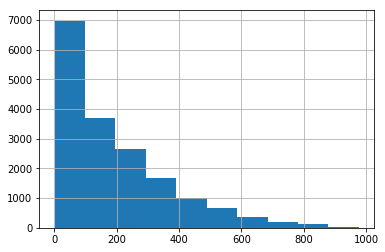

In [28]:
df['cnt'].hist()

75% of data is under 281, but the rest 25% have way bigger values, and that is clearly non-linear dependency. Thus, the linear regression approach is not working.

# Decision Tree approach

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
dtr = DecisionTreeRegressor(random_state=1)

In [31]:
dtr.fit(train[features], train['cnt'])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [32]:
dtr_test_pred = evaluate_predictions(dtr, train, test)

RMSE TRAIN AND TEST:
61.57525017 139.013636821


In [33]:
dtr_check_df, avg_error = compare_predictions(dtr_test_pred, test, 'cnt')

In [36]:
dtr_check_df.head()

,Predicted cnt,cnt,"Error, %","Error, val"
1,5.0,40,87.500000,-35.0
3,18.0,13,38.461538,5.0
10,62.0,36,72.222222,26.0
17,157.0,67,134.328358,90.0
19,102.0,37,175.675676,65.0


In [37]:
avg_error

105.94301136135641

### Error is less now, but still huge

Even though error has shrunk ~2.+ times, it is about 100%. One thing that is clear by rmse for test and train is that there is a big variance (overfitting) in the model, much bigger than in linear regression model. That could be fixed with simplifying tree, or using random forest.

### Simplify tree

In [38]:
dtr.get_params()

{'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 1,
 'splitter': 'best'}

In [57]:
dtr_simplified = DecisionTreeRegressor(random_state=1, max_depth=10, min_samples_leaf=5)

In [58]:
dtr_simplified.fit(train[features], train['cnt'])
dtr_simplified_test_pred = evaluate_predictions(dtr_simplified, train, test)
dtr_simplified_check_df, avg_error = compare_predictions(dtr_simplified_test_pred, test, 'cnt')

RMSE TRAIN AND TEST:
98.3513520029 108.040301038


In [59]:
avg_error

95.62528596949964

The average error drops, but this is still unacceptably high.

# One possible solution to reduce bias is to introduce additional learning features.

In [60]:
new_features = df.corr()['cnt'].index.values.tolist()

In [61]:
features_to_remove = ['instant', 'casual', 'registered', 'cnt']
for ft in features_to_remove:
    new_features.remove(ft)

In [62]:
new_features

['season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'time_label',
 'time_label_0',
 'time_label_1',
 'time_label_2',
 'time_label_3']

### Quick check with Linear Regression

In [63]:
lr = LinearRegression()
lr.fit(train[new_features], train['cnt'])
lr_test_pred = evaluate_predictions(lr, train, test, new_features)
print(avg_error)

RMSE TRAIN AND TEST:
129.280755241 127.1481919
95.62528596949964


Much better result with linear regression

### Decision Tree check

In [70]:
dtr_simplified = DecisionTreeRegressor(random_state=1, min_samples_leaf=5)

dtr_simplified.fit(train[new_features], train['cnt'])
dtr_simplified_test_pred = evaluate_predictions(dtr_simplified, train, test, new_features)
dtr_simplified_check_df, avg_error = compare_predictions(dtr_simplified_test_pred, test, 'cnt')

RMSE TRAIN AND TEST:
34.4399898143 54.4249062726


In [71]:
print(avg_error)

34.863080431863104


It is likely that it's possible to get better results with that dataset.

One thing is that we can possibly reduce overfitting even further with Random Forests.

# Random Forest approach

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
rfc = RandomForestRegressor(n_estimators=15, random_state=1, min_samples_leaf=2)

In [74]:
rfc.fit(train[new_features], train['cnt'])
rfc_test_pred = evaluate_predictions(rfc, train, test, new_features)
rfc_check_df, avg_error = compare_predictions(rfc_test_pred, test, 'cnt')

RMSE TRAIN AND TEST:
24.2319059767 43.7371226964


In [75]:
print(avg_error)

30.976005292640963


Both bias and variance reduced with random forest. Decrease of overfitting is explained by the nature of model (Random Forests have many sub-models with different parameters that lowers overfitting by definition), and decrease of bias is a bit unusual, but still possible by the same principle.

Additional improvements in accuracy of the model could be made and it would probably include pre-calculation of some additional features (probably some non-linear combinations of existing features).